In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import multiprocessing

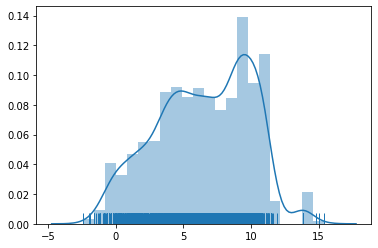

In [63]:
TEST_SIZE = 0.3
SEED = 123
np.random.seed(SEED)

df = pd.read_csv("Data/bioactivity_clean.csv")

# generate fingeprints: Morgan fingerprint with radius 2
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2) for smile in df["CANONICAL_SMILES"]]

# convert the RDKit explicit vectors into numpy arrays
np_fps = [np.zeros((1,)) for fp in fps]
for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, np_fps[i])
X = pd.DataFrame(np.array(np_fps))
y = df["STANDARD_VALUE"].values
y = pd.Series(np.log(y))
assert np.isnan(y).sum()==0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

sns.distplot(y, rug=True)

In [67]:
# Do cross-validation
N_SEARCH_ITER = 20 # Number of models tested in the random search
K = 4 # Number of folds in stratified cross-validation
N_JOBS = multiprocessing.cpu_count()-1 # Number of threads

rf = RandomizedSearchCV(
    RandomForestRegressor(),
    {
        'n_estimators' : np.arange(100, 1000, 100),
        'max_features' : ['sqrt', 'log2'],
        'max_depth' : [None] + list(range(100))
    },
    n_iter=N_SEARCH_ITER,
    cv=K,
    random_state=SEED,
    n_jobs=N_JOBS,
    verbose=1
).fit(X_train, y_train)

plt.scatter(y_test, rf.predict(X_test))
plt.xlabel("truth")
plt.ylabel("predicted")
plt.title("r^2 on test set: {:.2f}".format(rf.score(X_test, y_test)))

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  12 out of  12 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  12 out of  12 | elapsed:   14.2s finished


Text(0.5, 1.0, 'r^2 on test set: 0.73')

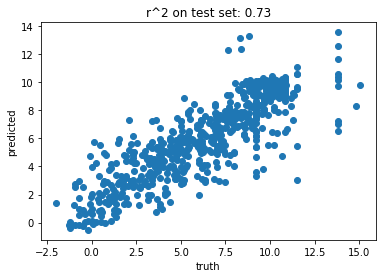

In [68]:
plt.scatter(y_test, rf.predict(X_test))
plt.xlabel("truth")
plt.ylabel("predicted")
plt.title("r^2 on test set: {:.2f}".format(rf.score(X_test, y_test)))

In [96]:
# Get the best candidates
y_test_hat = pd.DataFrame(rf.predict(X_test), index=X_test.index, columns=["yhat"])
y_test_hat = y_test_hat.sort_values("yhat")
best_idxs = y_test_hat.index[:10]

df.iloc[ best_idxs ][["CMPD_CHEMBLID", "CANONICAL_SMILES"]] # These are the best candidates

,CMPD_CHEMBLID,CANONICAL_SMILES
1006,CHEMBL180146,C[C@H]1[C@@H]([C@@H](Oc2ccc(O)c(F)c12)c3ccc(OC...
1003,CHEMBL427324,CC(C)[C@H]1CCN(CCOc2ccc(cc2)[C@@H]3Oc4ccc(O)cc...
13,CHEMBL184360,Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN...
352,CHEMBL178334,CC(C)N1CCN(CC1)c2ccc(cc2)C(=O)c3c(sc4cc(O)ccc3...
682,CHEMBL182980,C[C@H]1CN(CCOc2ccc(cc2)[C@@H]3Oc4ccc(O)cc4S[C@...
353,CHEMBL183467,C[C@@H]1CN(CCOc2ccc(cc2)[C@@H]3Oc4ccc(O)cc4S[C...
1281,CHEMBL366928,Oc1ccc(cc1)c2sc3cc(O)ccc3c2C(=O)c4ccc(cc4)N5CC...
2041,CHEMBL362020,Oc1ccc(cc1)c2sc3cc(O)ccc3c2C(=O)c4ccc(cc4)N5CC...
21,CHEMBL185231,Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN...
1547,CHEMBL433769,Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN...
